In [ ]:
from typing import List, TypedDict
from langgraph.graph import StateGraph,START,END
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
import os
import json
import requests


In [ ]:
"""Podłączenie do API OpenAI """
load_dotenv() 
chat_llm = ChatOpenAI(model="gpt-4o") 

In [ ]:
class AgentState(TypedDict):
    description: str
    picture: str

SYSTEM_PROMPT = (
    "Jesteś asystentem, który generuje obrazki jedzenia na podstawie opisu. "
    "Reaguj tylko na opisy obrazków jedzenia, które otrzymujesz od użytkownika. "
    "Nie odpowiadaj na żadne inne pytania ani prośby. "
    "Jeśli otrzymasz opis, wygeneruj odpowiedni obrazek jedzenia i zwróć jego URL."
)
import openai

def generate_food_picture(state: AgentState) -> AgentState:
    client = openai.OpenAI()
    response = client.images.generate(
        model="dall-e-3",
        prompt=state['description'],
        n=1,
        size="1024x1024"
    )
    image_url = response.data[0].url
    state['picture'] = image_url
    return state

def chat_node(state: AgentState):
    """Funkcja do komunikacji z chatem"""
    messages = [
        SystemMessage(content=SYSTEM_PROMPT),
        HumanMessage(content=state["description"])
    ]
    response = chat_llm.invoke(messages)
    print(response.content)
    return state

In [ ]:
graph = StateGraph(AgentState)
graph.add_node("chat_node", chat_node)
graph.add_node("generate_food_picture", generate_food_picture)
graph.add_edge("chat_node", "generate_food_picture")
graph.add_edge(START, "chat_node")
graph.add_edge("generate_food_picture", END)
app = graph.compile()

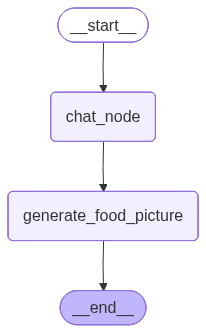

In [ ]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
from IPython.display import display, Image
import requests

user_input = input("Jaki obraz jedzenia chcesz zobaczyć: ")
result = app.invoke({"description": user_input, "picture": ""})
image_url = result.get("picture")
if image_url:
    response = requests.get(image_url)
    if response.status_code == 200:
        display(Image(response.content))
    else:
        print("Nie udało się pobrać obrazka.")
else:
    print("Brak wygenerowanego obrazka.")

![Banan](https://example.com/banana-image)
